In [1]:
!ls

config				rcaug_model-8filt-seed5.ipynb
inputs.gz			rcaug_model-seed5.ipynb
labels.gz			rcweights_8filt_model.ipynb
lockdir_runs_perf-metric-auROC	runs_perf-metric-auROC.db
model_files			snapshots
prepSplits.sh			splits
rc				test_data.hdf5
rcaug_model-16filt-seed0.ipynb	train_data.hdf5
rcaug_model-8filt-seed0.ipynb	valid_data.hdf5
rcaug_model-8filt-seed1.ipynb	yaml
rcaug_model-8filt-seed2.ipynb


In [2]:
#prefix="K0SFz"; record="71" #rcaug
prefix="sKtsW"; record="72" #norcaug, perf 86.9
final_model_weights = "model_files/record_"+record+"_model_"+prefix+"_modelWeights.h5"
model_json = "model_files/record_"+record+"_model_"+prefix+"_modelJson.json"

In [3]:
from keras.models import model_from_json
model = model_from_json(open(model_json).read())

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [19]:
import numpy as np

conv_weights_over_epochs = []
conv_biases_over_epochs = []

#track the evolution of filter params
for i in range(80):
    epoch_weights = "snapshots/"+prefix+"/start_epoch"+str(i)+"_model_"+prefix+"_modelWeights.h5"
    model.load_weights(epoch_weights)
    conv_weights, conv_biases = model.layers[0].get_weights()
    conv_weights_over_epochs.append(conv_weights)
    conv_biases_over_epochs.append(conv_biases)

conv_weights_over_epochs = np.squeeze(np.array(conv_weights_over_epochs))
conv_biases_over_epochs = np.array(conv_biases_over_epochs)

#mean norm the weights
#weights have dim [epoch, len, ACGT, chan]
mean_per_epoch_per_pos_per_chan = np.mean(conv_weights_over_epochs,axis=-2)
conv_weights_over_epochs = conv_weights_over_epochs - mean_per_epoch_per_pos_per_chan[:,:,None,:]
conv_biases_over_epochs = conv_biases_over_epochs + np.sum(mean_per_epoch_per_pos_per_chan,axis=1) #essential for cleaning up the biases plot


In [20]:
#compute the total change in weights from epoch to epoch
deltas = np.abs(conv_weights_over_epochs[:-1] - conv_weights_over_epochs[1:])
deltas = np.sum(np.sum(deltas,axis=1),axis=1) #sum up the change over axes that aren't channel axis

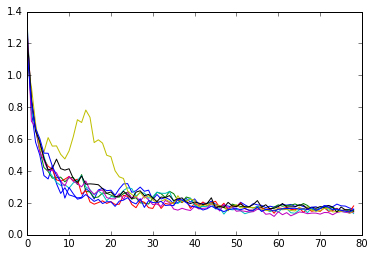

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(deltas.shape[1]):
    plt.plot(deltas[:,i])

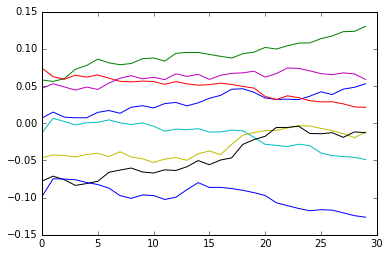

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(conv_biases_over_epochs.shape[1]):
    plt.plot(conv_biases_over_epochs[:,i])

In [8]:
#compute importance scores
from momma_dragonn.data_loaders.hdf5_data_loader import MultimodalAtOnceDataLoader
data_loader = MultimodalAtOnceDataLoader(path_to_hdf5="valid_data.hdf5",
                                         bundle_x_and_y_in_generator=False,
                                         strip_enclosing_dictionary=True)
data = data_loader.get_data()

('Input modes', [u'sequence'])
('Output modes', [u'output'])
('num_to_load_for_eval is ', None, 'but num_items is', 6430, '- fixing')


In [9]:
from keras import backend as K
import theano
score_func = theano.function([model.input, K.learning_phase()],
                             (theano.grad(K.sum(model.layers[-2].output[:,0],axis=0), model.layers[0].output)*model.layers[0].output),
                             allow_input_downcast=True)

In [10]:
from deeplift.util import run_function_in_batches
channel_scores = np.array(run_function_in_batches(score_func, input_data_list=[data.X], learning_phase=False, batch_size=100))

Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000


In [11]:
channel_scores_rcd = channel_scores[:,:,:channel_scores.shape[-1]/2] + channel_scores[:,:,(channel_scores.shape[-1]/2):][:,::-1,::-1]

In [12]:
channel_scores_pos = np.array([x for x,y in zip(channel_scores_rcd,data.Y) if y==1])
channel_scores_neg = np.array([x for x,y in zip(channel_scores_rcd,data.Y) if y==0])

In [13]:
channel_scores_pos = np.mean(np.sum((channel_scores_pos),axis=1),axis=0)
channel_scores_neg = np.mean(np.sum((channel_scores_neg),axis=1),axis=0)
diff = channel_scores_pos - channel_scores_neg

(array([ 7.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  1.53732300e-03,   2.56657004e-01,   5.11776686e-01,
          7.66896367e-01,   1.02201605e+00,   1.27713573e+00,
          1.53225541e+00,   1.78737509e+00,   2.04249477e+00]),
 <a list of 8 Patch objects>)

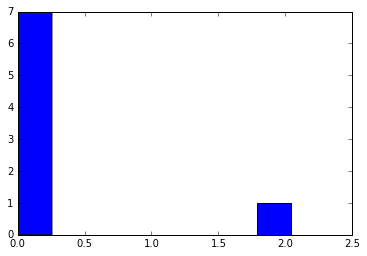

In [14]:
import matplotlib.pyplot as plt
plt.hist(diff,bins=len(diff))

In [15]:
#sort the channels by their scores
sorted_channels = sorted(enumerate(diff),key=lambda x: -x[1])

In [16]:
len(sorted_channels)

8

('channel', 5, 'score:', 2.0424948)
('bias:', -0.012035996)


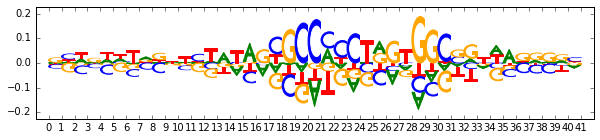

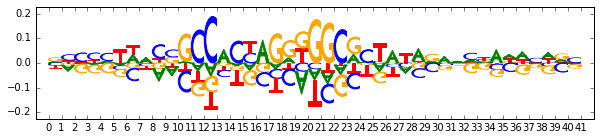

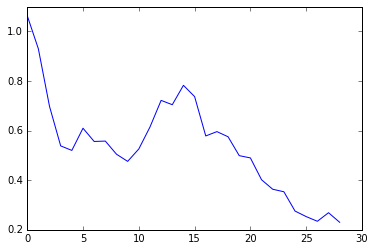

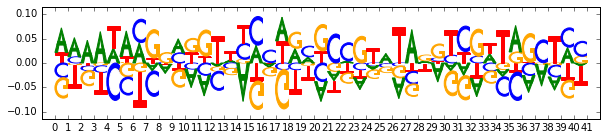

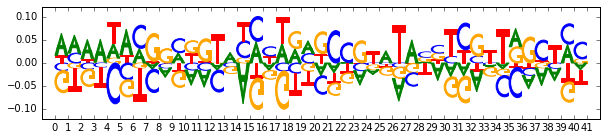

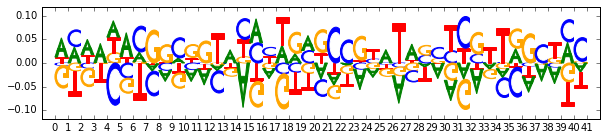

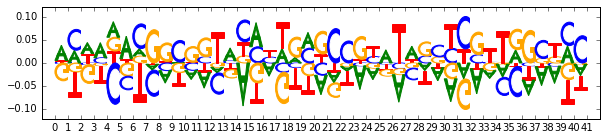

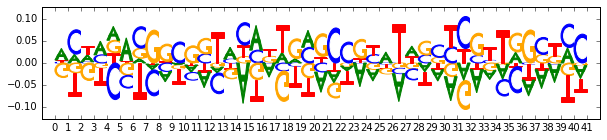

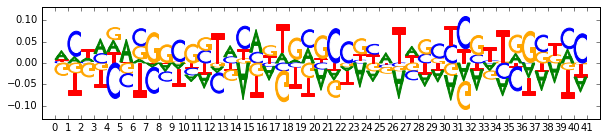

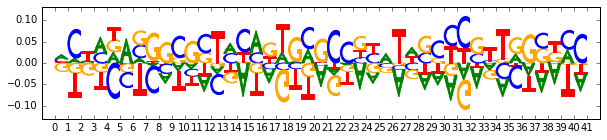

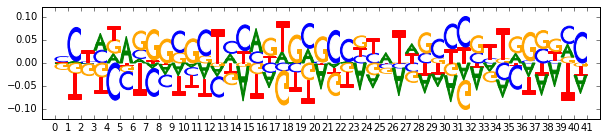

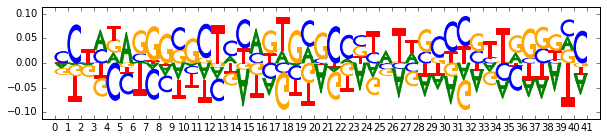

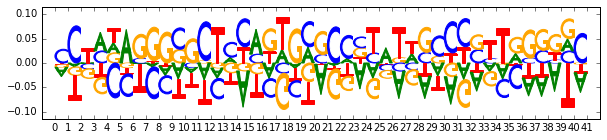

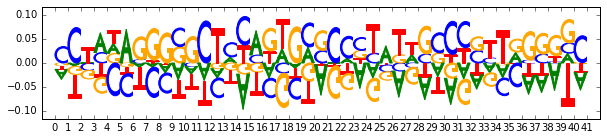

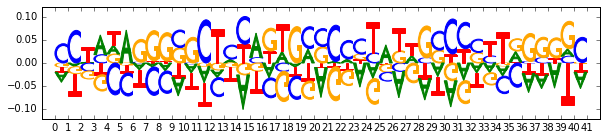

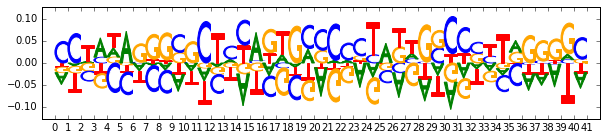

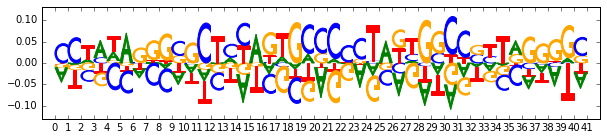

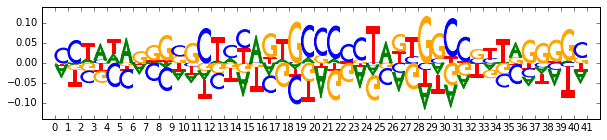

('channel', 6, 'score:', 0.24797833)
('bias:', -0.012739502)


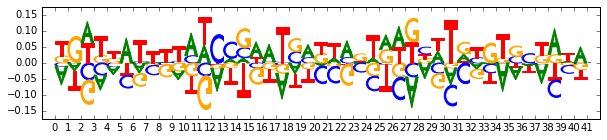

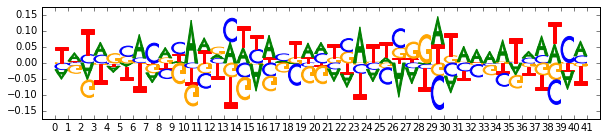

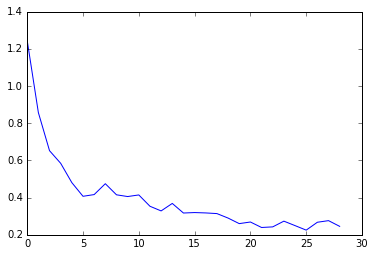

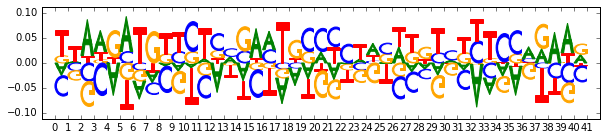

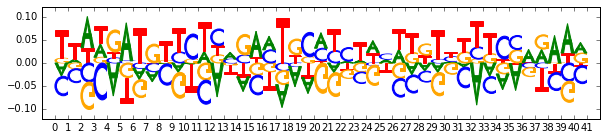

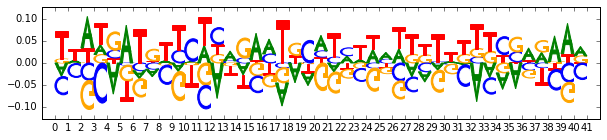

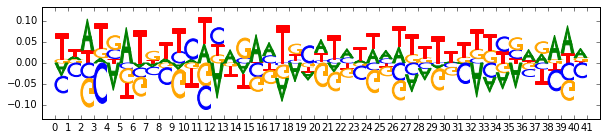

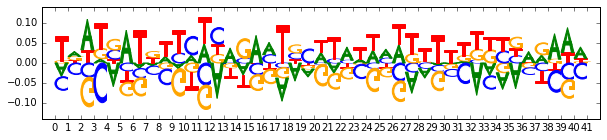

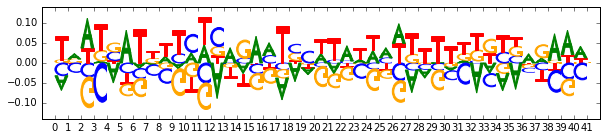

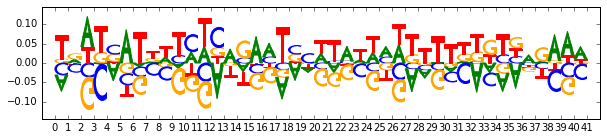

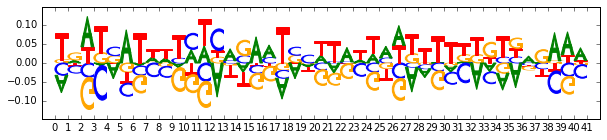

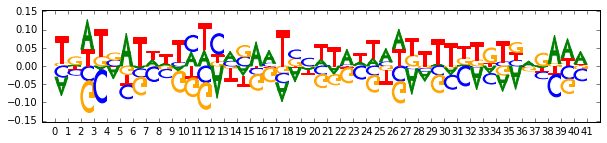

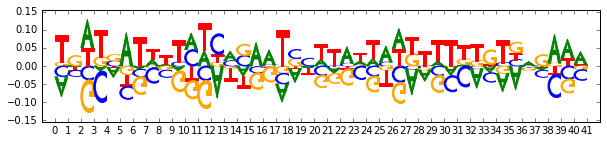

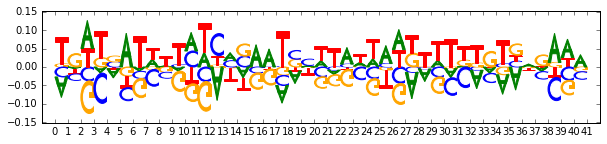

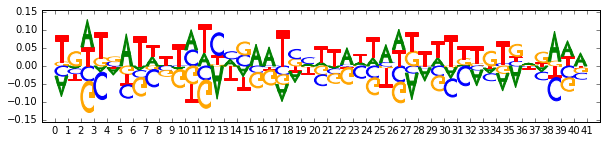

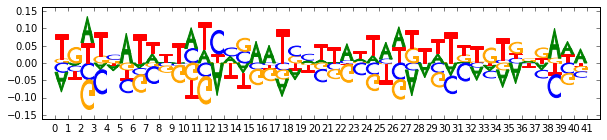

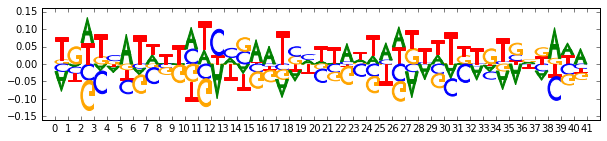

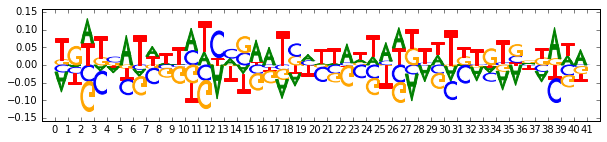

('channel', 1, 'score:', 0.11519861)
('bias:', 0.13013671)


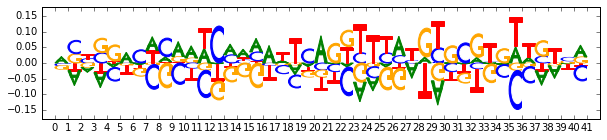

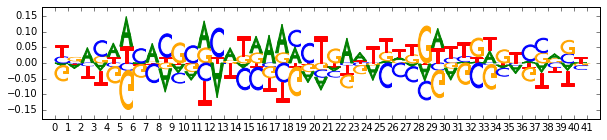

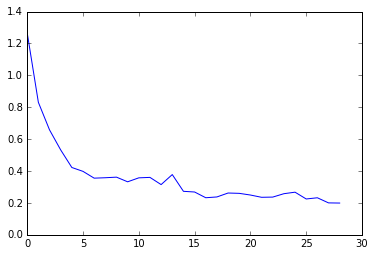

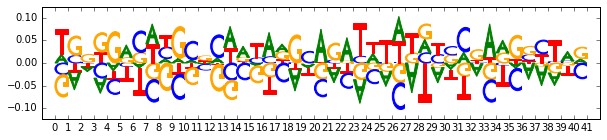

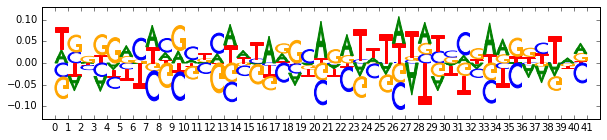

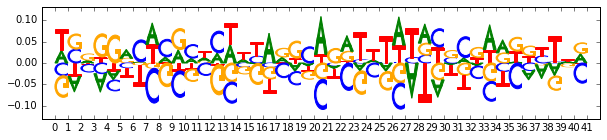

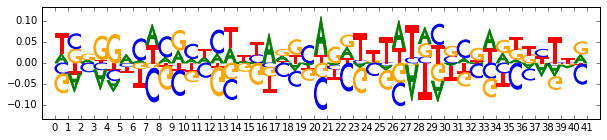

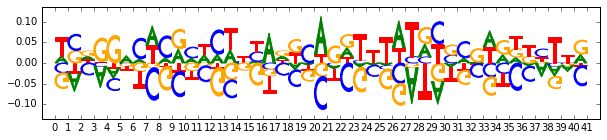

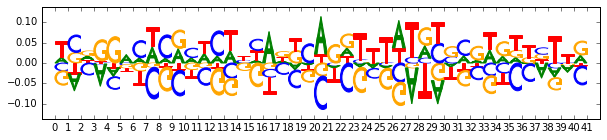

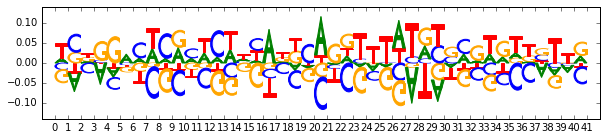

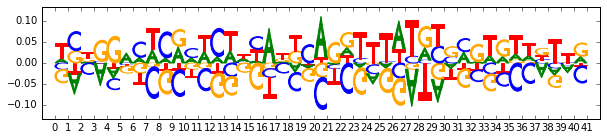

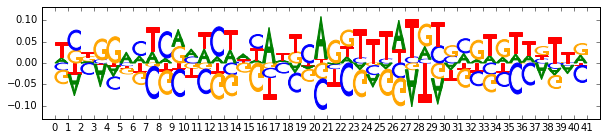

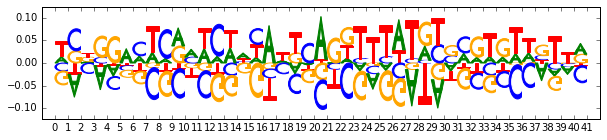

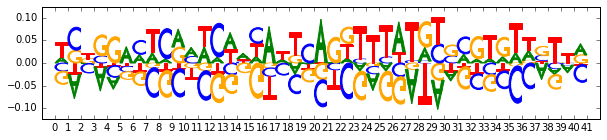

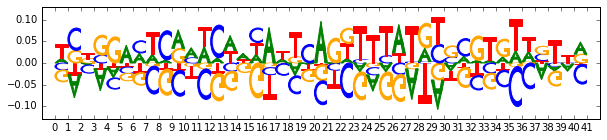

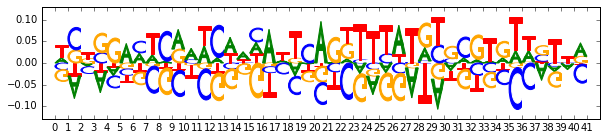

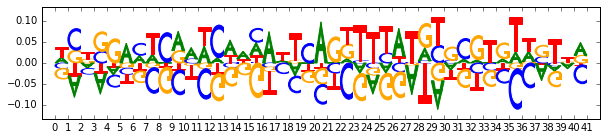

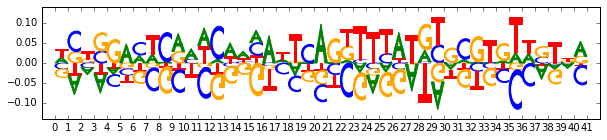

('channel', 0, 'score:', 0.10640979)
('bias:', 0.053081434)


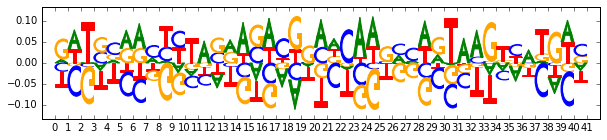

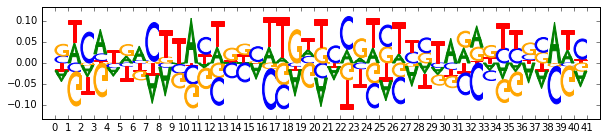

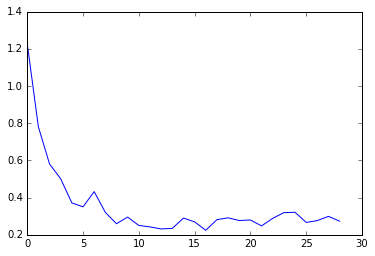

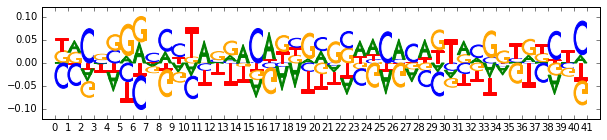

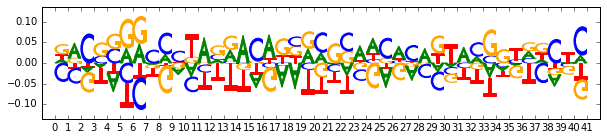

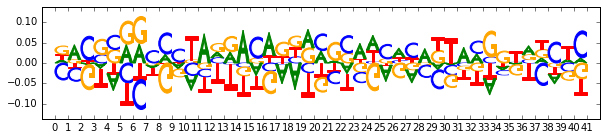

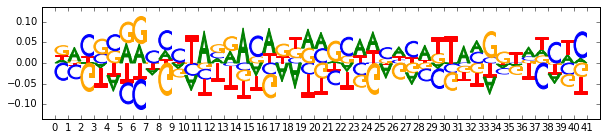

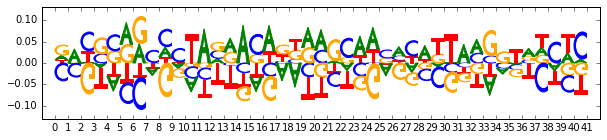

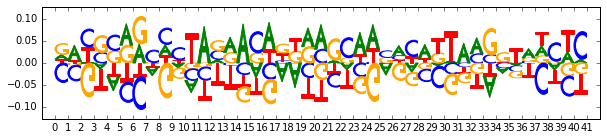

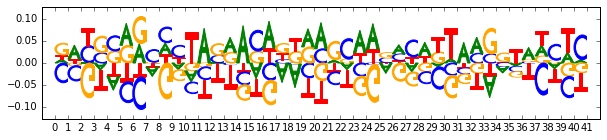

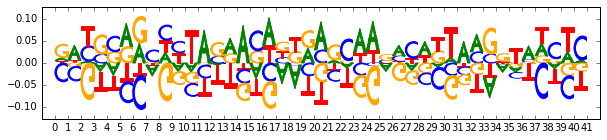

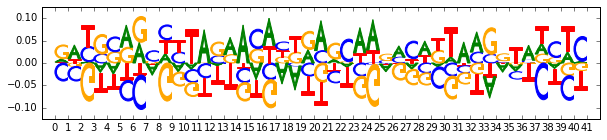

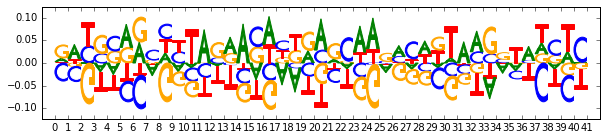

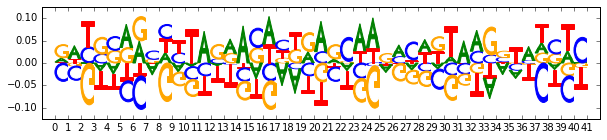

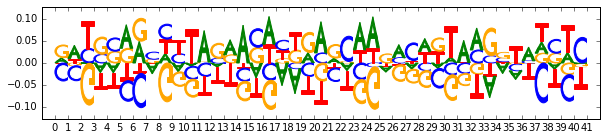

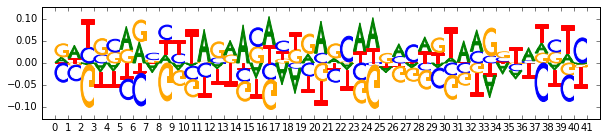

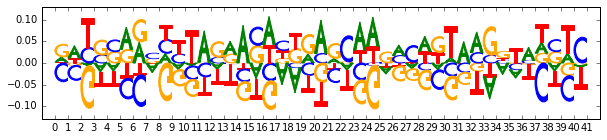

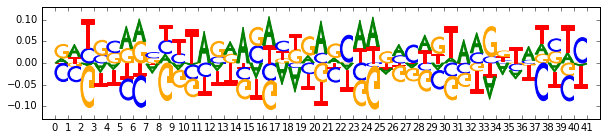

('channel', 7, 'score:', 0.092555642)
('bias:', -0.12635049)


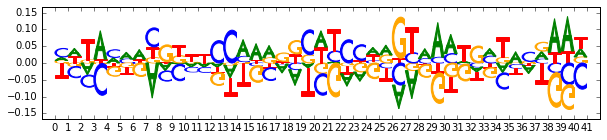

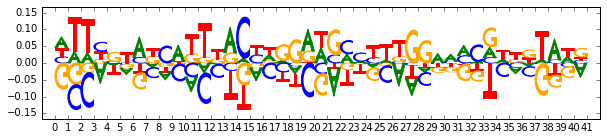

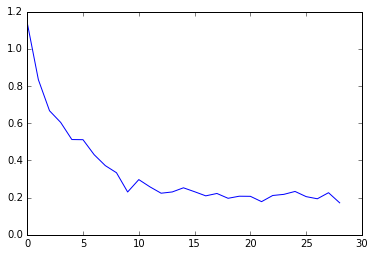

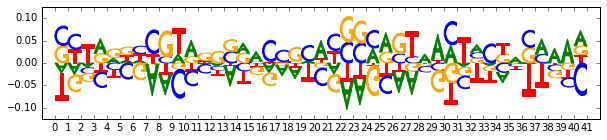

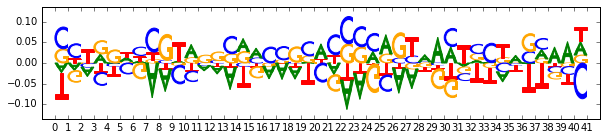

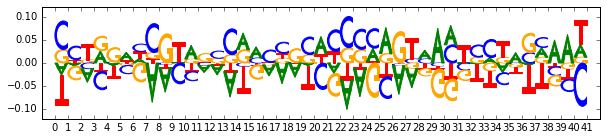

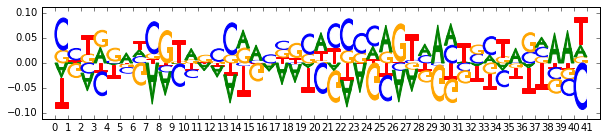

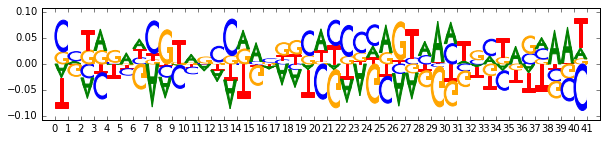

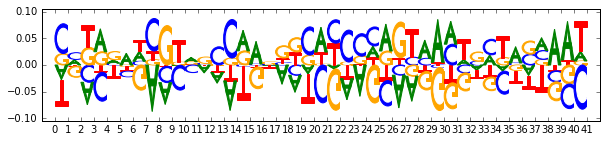

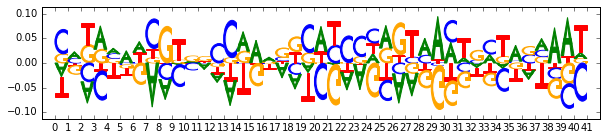

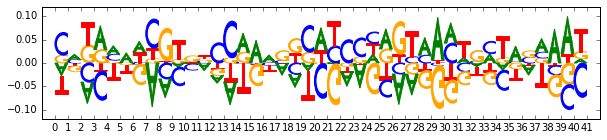

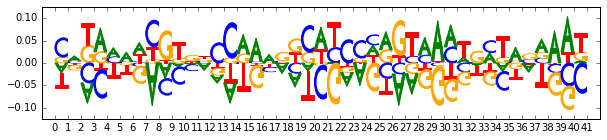

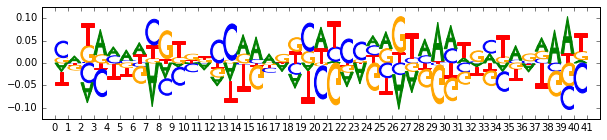

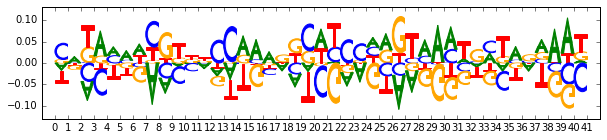

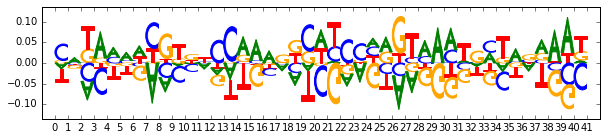

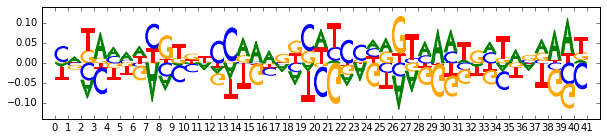

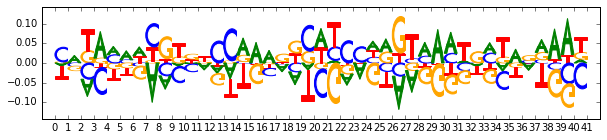

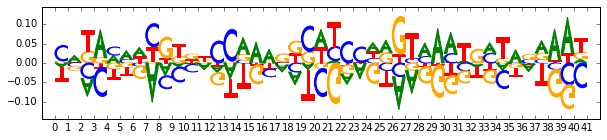

In [18]:
from deeplift.visualization import viz_sequence
for (i, channel_score) in sorted_channels[:5]:
    print("channel",i,"score:",channel_score)
    final_weights = conv_weights_over_epochs[-1,:,:,i]
    final_bias = conv_biases_over_epochs[-1,i]
    print("bias:",final_bias)
    viz_sequence.plot_weights(final_weights[::-1,:], figsize=(10,2)) #convolution so rev length dim but not channel
    viz_sequence.plot_weights(final_weights[::,::-1], figsize=(10,2)) #convolution so rev length dim but not channel

    plt.plot(deltas[:,i])
    plt.show()
    for epoch in range(15):
        viz_sequence.plot_weights(conv_weights_over_epochs[epoch,::-1,:,i], figsize=(10,2))
    

In [69]:
conv_weights_over_epochs.shape

(80, 41, 1, 4, 16)